In [44]:
import mesma 
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\attic\miniconda3\envs\hls_env\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


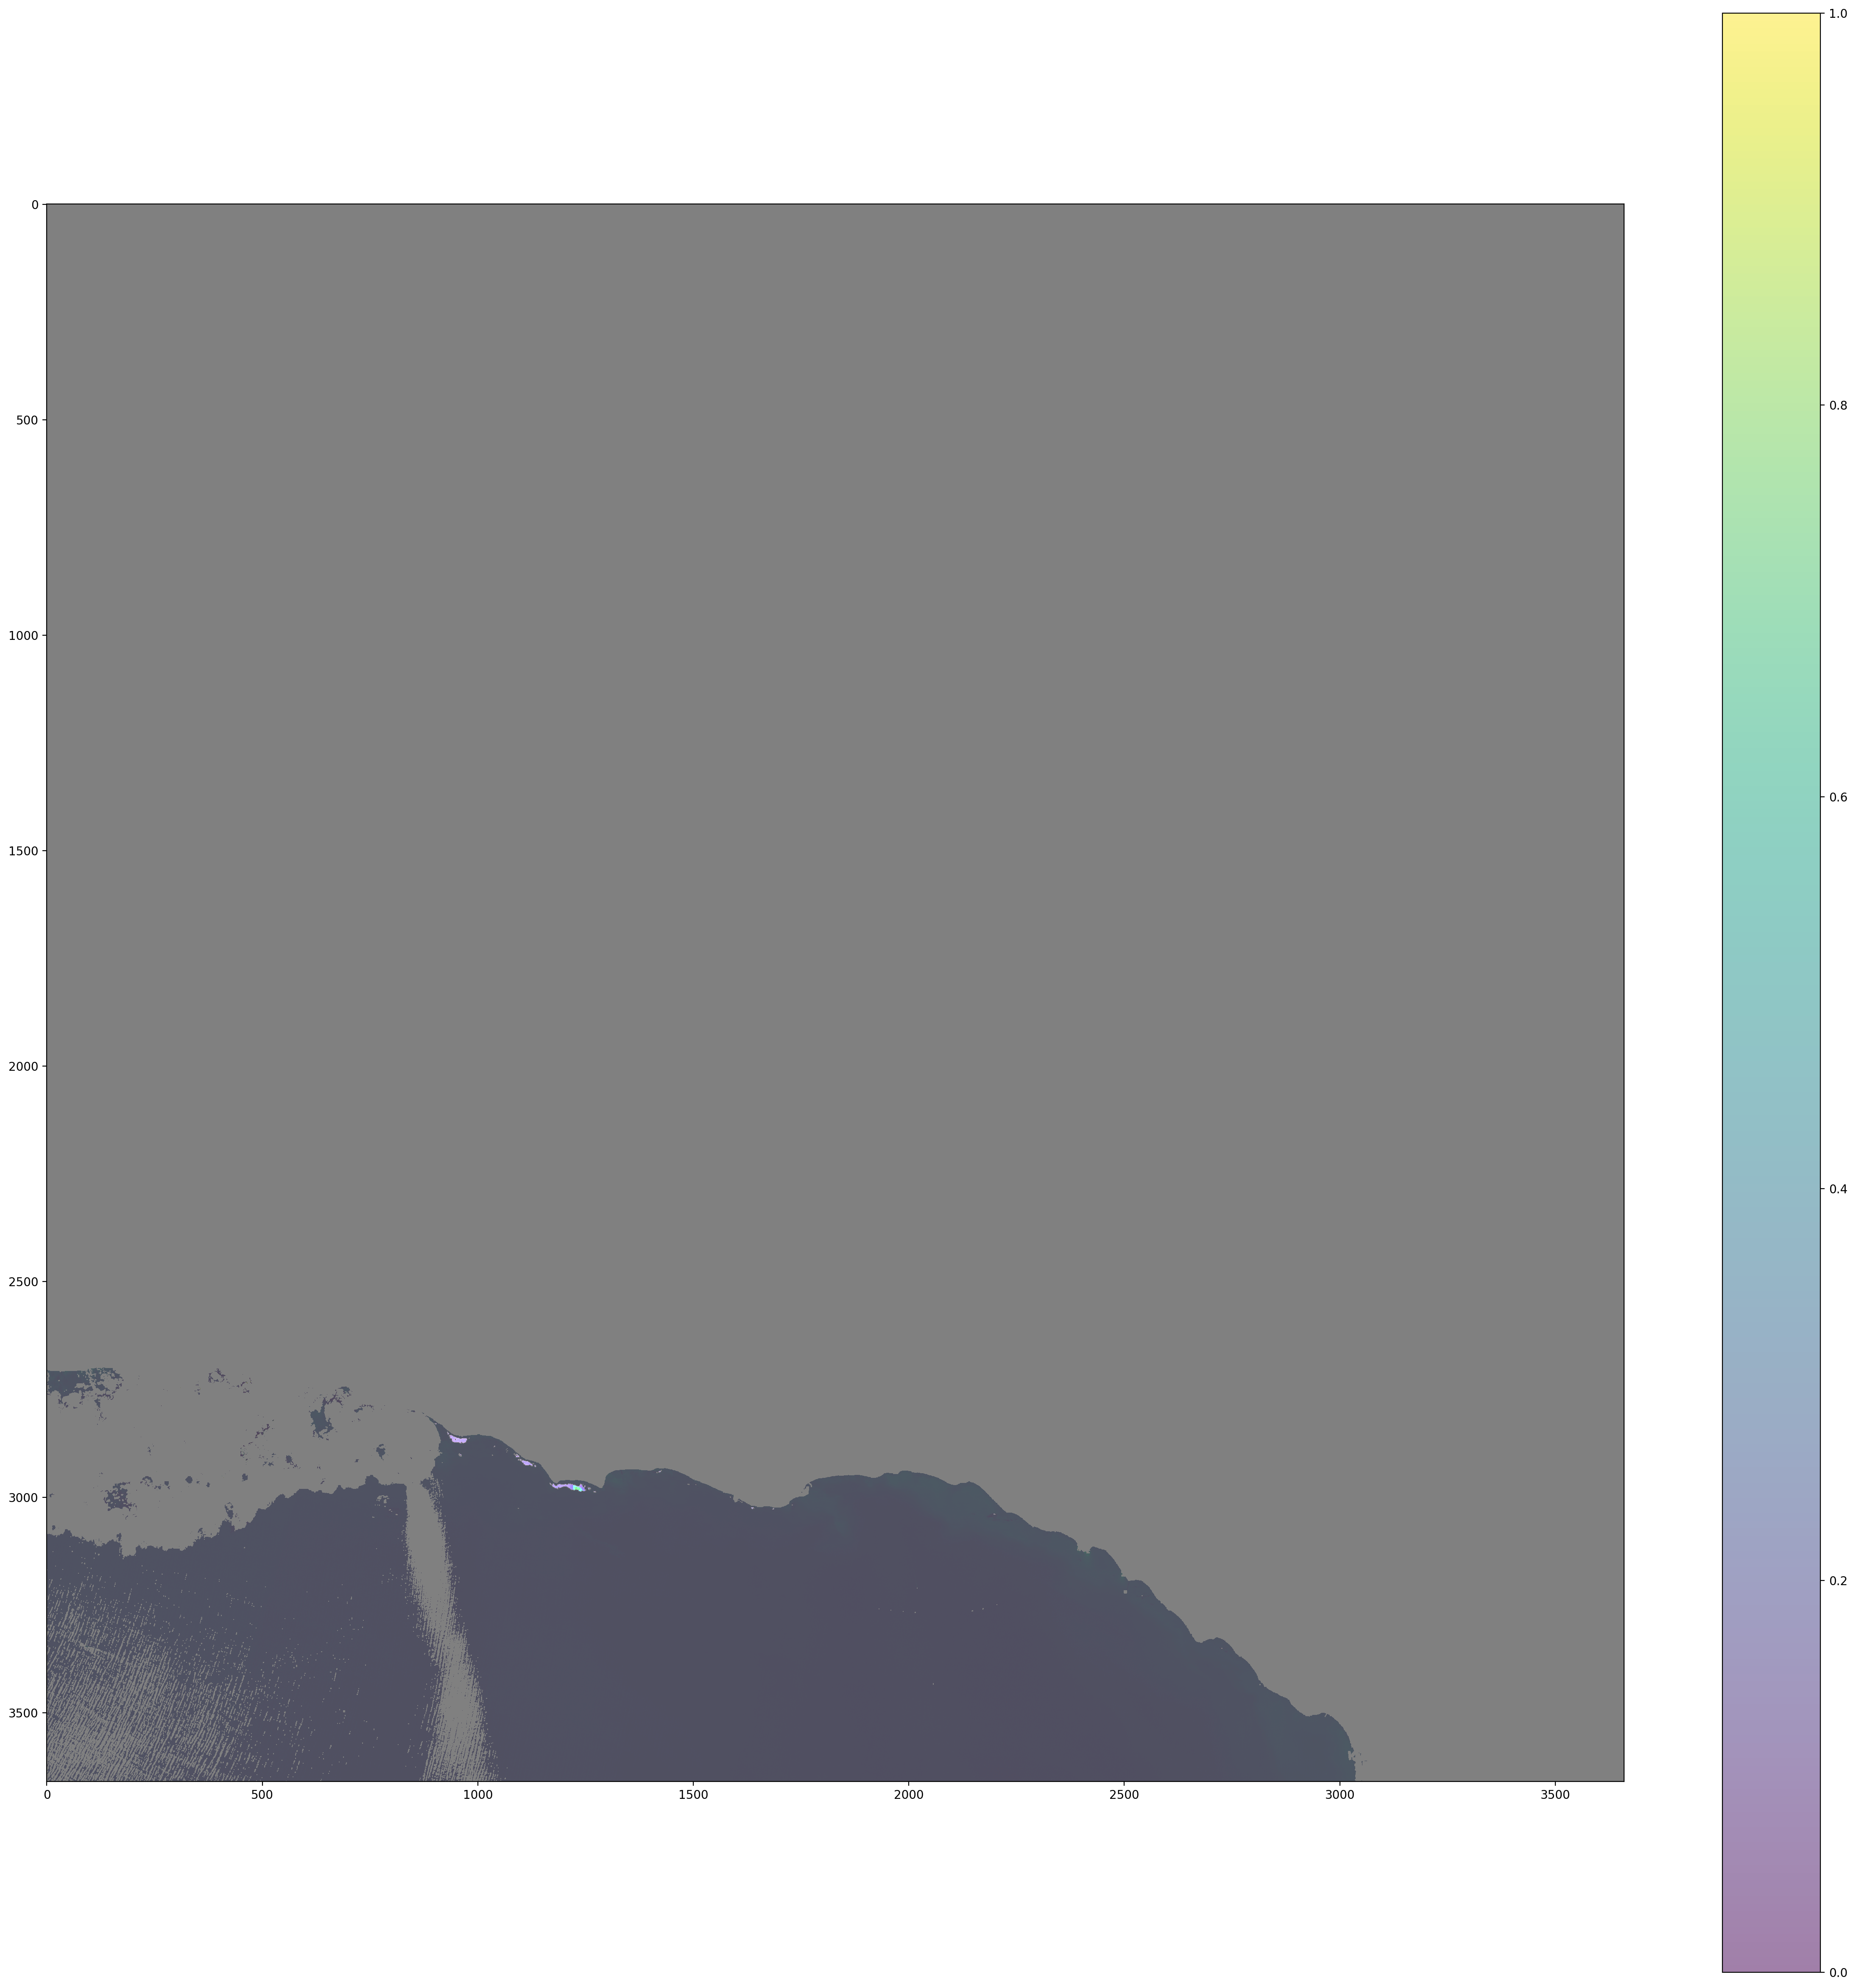

In [69]:
path = r'C:\Users\attic\HLS_Kelp\imagery\rf_training\HLS.L30.T11SKU.2018106T183324.v2.0_kelp_classified.tif'
with rasterio.open(path) as imagery:
    classified_img = imagery.read(7)
    kelp_mask  = []
    ocean_mask = []
    for i in range(6):
        band_data = imagery.read(i + 1)
        kmask = np.where(classified_img !=0, np.nan, band_data)
        omask = np.where(classified_img != 1, np.nan, band_data)
        kelp_mask.append(kmask)
        ocean_mask.append(omask)
    kelp_mask = np.array(kelp_mask)
    ocean_mask = np.array(ocean_mask)
#print(classified_img)
rgb_nor = np.stack([kelp_mask[1]/60,kelp_mask[2]/60,kelp_mask[3]/60], axis=-1)
rgb_nor_cropped = rgb_nor
#print(kelp_mask)
rgb_nor_cropped = np.ma.masked_where(np.isnan(rgb_nor_cropped), rgb_nor_cropped)
image = ocean_mask[1]
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(image, alpha=.5)
plt.imshow(rgb_nor_cropped, alpha=.5)
plt.colorbar()
plt.show()

In [52]:
ocean_EM = []
 Kelp = [459; 556; 437; 1227]
kelp_EM
ocean_EM_n = 0
ocean_data = ocean_mask.reshape(ocean_mask.shape[0], -1)
print(ocean_data.shape)
ocean_data = ocean_data[:, ~np.isnan(ocean_data).any(axis=0)]

for i in range(30):
     index = random.randint(0,len(ocean_data[0])-1)
     ocean_EM.append(ocean_data[:,index])
print(ocean_EM)

    


(6, 13395600)
[array([34., 48., 34., 38., 51., 47.]), array([ 0., 52., 23., 28., 76., 74.]), array([30., 49., 34., 38., 52., 49.]), array([12., 48., 33., 39., 60., 58.]), array([11., 51., 22., 33., 68., 67.]), array([30., 53., 39., 41., 47., 41.]), array([15., 56., 16., 21., 73., 72.]), array([29., 50., 37., 38., 50., 47.]), array([224.,  49.,  11.,  28.,  99.,  98.]), array([ 7., 44., 28., 37., 69., 68.]), array([244.,  52.,  21.,  29.,  81.,  82.]), array([31., 47., 38., 41., 50., 45.]), array([251.,  49.,  26.,  32.,  77.,  75.]), array([45., 57., 37., 38., 40., 35.]), array([ 0., 54., 22., 28., 73., 76.]), array([25., 48., 37., 41., 53., 48.]), array([40., 51., 40., 39., 42., 39.]), array([30., 51., 37., 40., 50., 45.]), array([219.,  50.,   7.,  25., 103., 105.]), array([38., 50., 40., 40., 44., 39.]), array([16., 53., 36., 36., 57., 54.]), array([250.,  51.,  19.,  26.,  80.,  83.]), array([10., 47., 28., 36., 66., 66.]), array([ 5., 49., 24., 37., 69., 69.]), array([33., 48., 38

In [67]:
help(mesma)

help(execute)

Help on package mesma:

NAME
    mesma - This script initializes the plugin, making it known to QGIS.

PACKAGE CONTENTS
    core (package)
    hubdc (package)
    interfaces (package)
    mesma_plugin
    qps (package)

FUNCTIONS
    classFactory(iface)
        Load Viper class from file viper.
        :param iface: A QGIS interface instance.
        :type iface: QgsInterface

FILE
    c:\users\attic\miniconda3\envs\hls_env\lib\site-packages\mesma\__init__.py


